# 作业3：深度学习框架实践

本次作业将练习深度学习框架的使用，大部分内容用 PyTorch 实现。第1题利用卷积层和全连接层实现手写数字的识别，第2题利用 RNN 来实现英文名的自动生成，第3题是算法题，利用卷积运算实现任意大整数的乘法。

### 第1题

1. 目标：通过对 MNIST 数据进行训练，构建一个简单的图像分类模型，对图片中的数字进行识别。你将利用该模型对自己真实手写出的数字进行预测，观察模型效果。

2. 主要步骤：获取数据，创建模型结构，定义损失函数，编写训练循环，实施预测。

3. 获取数据。我们使用知名的 MNIST 数据集，它可以从 PyTorch 中利用工具函数下载得到。原始的 MNIST 数据训练集大小为60000，我们随机抽取其中的10000个观测进行简单的训练。以下函数会在当前目录建立一个名为 data 的文件夹，其中会包含下载得到的数据集。

**注意：请在任何程序的最开始加上随机数种子的设置。请保持这一习惯。**

In [1]:
import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

np.random.seed(123)
torch.manual_seed(123)

In [2]:
mnist = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
loader = DataLoader(mnist, batch_size=10000, shuffle=True)

我们一次性取出随机抽取到的10000个观测，其中 x 是图片数据，y 是图片对应的数字。

In [3]:
x, y = next(iter(loader))

一个习惯性动作是查看数据的大小和维度。

In [4]:
print(x.shape)
print(y.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10000])


我们可以利用下面的函数展示图片的内容。如选择第一张图片，先将其转换成 Numpy 数组，再绘制图形：

(28, 28)


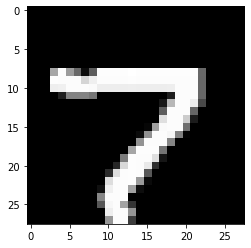

In [5]:
import matplotlib.pyplot as plt

img = x[0].squeeze().cpu().numpy()
print(img.shape)
plt.imshow(img, cmap="gray")
plt.show()

接下来请你选择5个你喜欢的数字（10000以下），然后取出对应位置的图片，并画出它们的内容。

(28, 28)


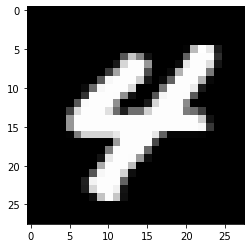

(28, 28)


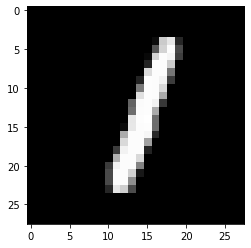

(28, 28)


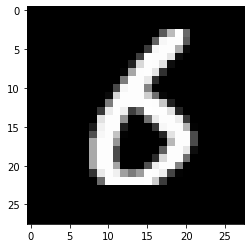

(28, 28)


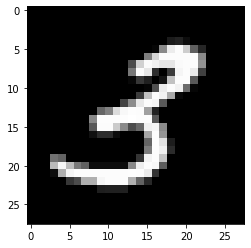

(28, 28)


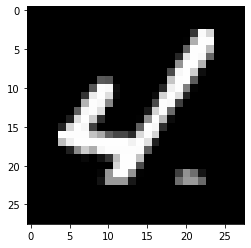

In [6]:
for num in [111,222,333,444,555]:
    img = x[num].squeeze().cpu().numpy()
    print(img.shape)
    plt.imshow(img, cmap="gray")
    plt.show()

4. 搭建模型。我们搭建一个类似于 LeNet-5 的网络，结构如下：

![](https://pic1.zhimg.com/80/v2-82eabb4c17e90d467197d013f7629f3c_720w.jpg)

我们需要创建2个卷积层、2个汇聚层（池化层）和2个全连接层，**暂时忽略所有的激活函数**。所有隐藏层的函数细节都可以在[官方文档](https://pytorch.org/docs/stable/nn.html)中按分类找到。每一个隐藏层本质上都是将一个数组变换成另一个数组的函数，因此为了确认编写的模型是正确的，可以先用一个小数据进行测试，观察输入和输出的维度。例如，我们先取出前10个观测，此时输入的维度是 `[10, 1, 28, 28]`：

In [7]:
smallx = x[0:10]
smally = y[0:10]
print(smallx.shape)
print(smally.shape)

torch.Size([10, 1, 28, 28])
torch.Size([10])


接下来创建第1个卷积层，并测试输出的维度。注意到我们可以直接将隐藏层当成一个函数来调用。

In [8]:
conv1 = torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
res = conv1(smallx)
print(res.shape)

torch.Size([10, 20, 24, 24])


可以看到，输出的维度为 `[20, 24, 24]`（不包括第1位的数据批次维度），与之前图中的结果吻合。

接下来，请按照图中提示编写层对象 `pool1`、`conv2`、`pool2`、`fc1` 和 `fc2`，并顺次测试输入与输出的维度，使其与上图匹配。注意，在将一个大小为 `[10, 50, 4, 4]` 的数组（假设叫 `somearray`）传递给 `fc1` 之前，需要先将其变形为只有两个维度的数组，做法是 `somearray.view(-1, 50*4*4)`，其中 -1 表示该位置的大小不变。

In [9]:
pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
res = pool1(res)
print(res.shape)

conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
res = conv2(res)
print(res.shape)

pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
res = pool2(res)
print(res.shape)

fc1 = torch.nn.Linear(50 * 4 * 4, 500)
res = fc1(res.view(-1, 50 * 4 * 4))
print(res.shape)

relu = torch.nn.ReLU()
res = relu(res)
print(res.shape)

fc2 = torch.nn.Linear(500, 10)
res = fc2(res)
print(res.shape)

softmax = torch.nn.Softmax(dim=1)
res = softmax(res)
print(res.shape)

torch.Size([10, 20, 12, 12])
torch.Size([10, 50, 8, 8])
torch.Size([10, 50, 4, 4])
torch.Size([10, 500])
torch.Size([10, 500])
torch.Size([10, 10])
torch.Size([10, 10])


5. 创建模型类。在确保隐藏层维度都正确后，将所有的隐藏层封装到一个模型类中，其中模型结构在 `__init__()` 中定义，具体的计算过程在 `forward()` 中实现。此时需要加入激活函数。在本模型中，**请在 `conv1`、`conv2` 和 `fc1` 后加入 ReLU 激活函数，并在 `fc2` 后加入 Softmax 激活函数**。

In [10]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(50 * 4 * 4, 500)
        self.fc2 = torch.nn.Linear(500, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.fc1(x.view(-1, 50 * 4 * 4))
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.softmax(x, dim=1)
        return x

再次测试输入输出的维度是否正确。如果模型编写正确，输出的维度应该是 `[10, 10]`，且输出结果为0到1之间的概率值。

In [12]:
np.random.seed(123)
torch.manual_seed(123)

model = MyModel()
pred = model(smallx)
print(pred.shape)
print(pred)
print(smally)

torch.Size([10, 10])
tensor([[0.0992, 0.0989, 0.0982, 0.1089, 0.0943, 0.0912, 0.0996, 0.1020, 0.1021,
         0.1056],
        [0.0997, 0.1004, 0.0978, 0.1085, 0.0938, 0.0907, 0.0982, 0.1045, 0.1020,
         0.1045],
        [0.0990, 0.0993, 0.0979, 0.1081, 0.0913, 0.0921, 0.0976, 0.1088, 0.1030,
         0.1031],
        [0.0955, 0.0996, 0.1010, 0.1081, 0.0931, 0.0913, 0.0988, 0.1044, 0.1031,
         0.1051],
        [0.0995, 0.0988, 0.0985, 0.1091, 0.0919, 0.0918, 0.0980, 0.1059, 0.1017,
         0.1049],
        [0.0977, 0.0994, 0.0996, 0.1073, 0.0924, 0.0922, 0.1018, 0.1019, 0.1040,
         0.1038],
        [0.0972, 0.1011, 0.1010, 0.1062, 0.0931, 0.0908, 0.1006, 0.1048, 0.1037,
         0.1016],
        [0.0996, 0.0984, 0.0987, 0.1068, 0.0904, 0.0900, 0.0992, 0.1076, 0.1020,
         0.1075],
        [0.0972, 0.0998, 0.1012, 0.1084, 0.0925, 0.0905, 0.1022, 0.1014, 0.1023,
         0.1045],
        [0.0979, 0.0998, 0.0985, 0.1080, 0.0959, 0.0910, 0.0979, 0.1049, 0.1027,
       

`pred` 的每一行加总为1，其中每一个元素代表对应类别的预测概率。

我们还可以直接打印模型对象，观察隐藏层的结构：

In [13]:
print(model)

MyModel(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


6. 损失函数。对于分类问题，损失函数通常选取为负对数似然函数。在 PyTorch 中，可以使用 `torch.nn.NLLLoss` 来完成计算。其用法是先定义一个损失函数对象，然后在预测值和真实标签上调用该函数对象。注意：损失函数对象的第一个参数是预测概率的**对数值**，第二个参数是真实的标签。[文档说明](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)。

In [14]:
lossfn = torch.nn.NLLLoss()
lossfn(torch.log(pred), smally)

tensor(2.3231, grad_fn=<NllLossBackward>)

7. 利用课上介绍的循环模板和代码示例，对模型进行迭代训练。对于本数据，选取 mini-batch 大小为200，共遍历数据10遍，优化器选为 Adam，学习率为0.001。

In [63]:
BATCH_SIZE = 200
EPOCH      = 10
LR         = 0.001

model  = MyModel()
loader = DataLoader(mnist, batch_size=BATCH_SIZE, shuffle=True)
opt    = torch.optim.Adam(model.parameters(), lr=0.001)
lossfn = torch.nn.NLLLoss()
for i in range(EPOCH):
    j = 0
    for x, y in loader:
        pred = model(x)
        loss = lossfn(torch.log(pred), y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        j += 1
        if (j // BATCH_SIZE) % 10 == 0:
            print(f"epoch {i+1}, batch {j+1}, loss = {loss.item()}")

epoch 0, batch 1, loss = 2.3062708377838135
epoch 0, batch 2, loss = 2.2662487030029297
epoch 0, batch 3, loss = 2.217352867126465
epoch 0, batch 4, loss = 2.156526565551758
epoch 0, batch 5, loss = 2.0445191860198975
epoch 0, batch 6, loss = 1.9561676979064941
epoch 0, batch 7, loss = 1.8460077047348022
epoch 0, batch 8, loss = 1.7074928283691406
epoch 0, batch 9, loss = 1.595689296722412
epoch 0, batch 10, loss = 1.3743484020233154
epoch 0, batch 11, loss = 1.2930766344070435
epoch 0, batch 12, loss = 1.2297788858413696
epoch 0, batch 13, loss = 1.0254333019256592
epoch 0, batch 14, loss = 0.9789087176322937
epoch 0, batch 15, loss = 0.8862656354904175
epoch 0, batch 16, loss = 0.7562286257743835
epoch 0, batch 17, loss = 0.8120880722999573
epoch 0, batch 18, loss = 0.6880616545677185
epoch 0, batch 19, loss = 0.6391095519065857
epoch 0, batch 20, loss = 0.6934168934822083
epoch 0, batch 21, loss = 0.5670079588890076
epoch 0, batch 22, loss = 0.4876691401004791
epoch 0, batch 23, los

epoch 0, batch 181, loss = 0.06629195809364319
epoch 0, batch 182, loss = 0.07971838116645813
epoch 0, batch 183, loss = 0.10388351231813431
epoch 0, batch 184, loss = 0.09996087104082108
epoch 0, batch 185, loss = 0.07845267653465271
epoch 0, batch 186, loss = 0.04842749238014221
epoch 0, batch 187, loss = 0.0733163133263588
epoch 0, batch 188, loss = 0.140195831656456
epoch 0, batch 189, loss = 0.10690390318632126
epoch 0, batch 190, loss = 0.06771335750818253
epoch 0, batch 191, loss = 0.051959529519081116
epoch 0, batch 192, loss = 0.12803632020950317
epoch 0, batch 193, loss = 0.0887066051363945
epoch 0, batch 194, loss = 0.06522863358259201
epoch 0, batch 195, loss = 0.14818891882896423
epoch 0, batch 196, loss = 0.07969710230827332
epoch 0, batch 197, loss = 0.13492965698242188
epoch 0, batch 198, loss = 0.08202555030584335
epoch 0, batch 199, loss = 0.04681164398789406
epoch 1, batch 1, loss = 0.08927862346172333
epoch 1, batch 2, loss = 0.04046344384551048
epoch 1, batch 3, lo

epoch 1, batch 159, loss = 0.055864885449409485
epoch 1, batch 160, loss = 0.03313896805047989
epoch 1, batch 161, loss = 0.10791648179292679
epoch 1, batch 162, loss = 0.06980407983064651
epoch 1, batch 163, loss = 0.07742577791213989
epoch 1, batch 164, loss = 0.07209393382072449
epoch 1, batch 165, loss = 0.07283291220664978
epoch 1, batch 166, loss = 0.03793560341000557
epoch 1, batch 167, loss = 0.031333278864622116
epoch 1, batch 168, loss = 0.027600280940532684
epoch 1, batch 169, loss = 0.03445244953036308
epoch 1, batch 170, loss = 0.04090753197669983
epoch 1, batch 171, loss = 0.11447129398584366
epoch 1, batch 172, loss = 0.07979805022478104
epoch 1, batch 173, loss = 0.0435931496322155
epoch 1, batch 174, loss = 0.026894161477684975
epoch 1, batch 175, loss = 0.06435298174619675
epoch 1, batch 176, loss = 0.0667998269200325
epoch 1, batch 177, loss = 0.11154774576425552
epoch 1, batch 178, loss = 0.04279303178191185
epoch 1, batch 179, loss = 0.036438655108213425
epoch 1, b

epoch 2, batch 137, loss = 0.027026213705539703
epoch 2, batch 138, loss = 0.04867221415042877
epoch 2, batch 139, loss = 0.021680451929569244
epoch 2, batch 140, loss = 0.020601162686944008
epoch 2, batch 141, loss = 0.049203887581825256
epoch 2, batch 142, loss = 0.0136695746332407
epoch 2, batch 143, loss = 0.07444575428962708
epoch 2, batch 144, loss = 0.023060068488121033
epoch 2, batch 145, loss = 0.0644705593585968
epoch 2, batch 146, loss = 0.0720953494310379
epoch 2, batch 147, loss = 0.052084263414144516
epoch 2, batch 148, loss = 0.07969390600919724
epoch 2, batch 149, loss = 0.041005924344062805
epoch 2, batch 150, loss = 0.037279583513736725
epoch 2, batch 151, loss = 0.03731745108962059
epoch 2, batch 152, loss = 0.047995977103710175
epoch 2, batch 153, loss = 0.04410340264439583
epoch 2, batch 154, loss = 0.012542725540697575
epoch 2, batch 155, loss = 0.037221573293209076
epoch 2, batch 156, loss = 0.04350011795759201
epoch 2, batch 157, loss = 0.05626704543828964
epoch

epoch 3, batch 115, loss = 0.0477493554353714
epoch 3, batch 116, loss = 0.12459567189216614
epoch 3, batch 117, loss = 0.058158788830041885
epoch 3, batch 118, loss = 0.02026744931936264
epoch 3, batch 119, loss = 0.0415709987282753
epoch 3, batch 120, loss = 0.012301316484808922
epoch 3, batch 121, loss = 0.01693156361579895
epoch 3, batch 122, loss = 0.024768244475126266
epoch 3, batch 123, loss = 0.045597635209560394
epoch 3, batch 124, loss = 0.03111327812075615
epoch 3, batch 125, loss = 0.016809113323688507
epoch 3, batch 126, loss = 0.02474023588001728
epoch 3, batch 127, loss = 0.02919384464621544
epoch 3, batch 128, loss = 0.04111257568001747
epoch 3, batch 129, loss = 0.03518546372652054
epoch 3, batch 130, loss = 0.02593463845551014
epoch 3, batch 131, loss = 0.020235631614923477
epoch 3, batch 132, loss = 0.06135888025164604
epoch 3, batch 133, loss = 0.04483520984649658
epoch 3, batch 134, loss = 0.024643681943416595
epoch 3, batch 135, loss = 0.024095673114061356
epoch 3

epoch 4, batch 91, loss = 0.029024654999375343
epoch 4, batch 92, loss = 0.029478197917342186
epoch 4, batch 93, loss = 0.020274769514799118
epoch 4, batch 94, loss = 0.006607164163142443
epoch 4, batch 95, loss = 0.052216872572898865
epoch 4, batch 96, loss = 0.016406310722231865
epoch 4, batch 97, loss = 0.01084564533084631
epoch 4, batch 98, loss = 0.017590779811143875
epoch 4, batch 99, loss = 0.0721297338604927
epoch 4, batch 100, loss = 0.008654020726680756
epoch 4, batch 101, loss = 0.048518262803554535
epoch 4, batch 102, loss = 0.024308206513524055
epoch 4, batch 103, loss = 0.015533163212239742
epoch 4, batch 104, loss = 0.039200130850076675
epoch 4, batch 105, loss = 0.020726921036839485
epoch 4, batch 106, loss = 0.028920037671923637
epoch 4, batch 107, loss = 0.004861426539719105
epoch 4, batch 108, loss = 0.04189920425415039
epoch 4, batch 109, loss = 0.05144326761364937
epoch 4, batch 110, loss = 0.011166797019541264
epoch 4, batch 111, loss = 0.029211824759840965
epoch 

epoch 5, batch 67, loss = 0.01848466880619526
epoch 5, batch 68, loss = 0.014031586237251759
epoch 5, batch 69, loss = 0.004739040974527597
epoch 5, batch 70, loss = 0.016915950924158096
epoch 5, batch 71, loss = 0.013273621909320354
epoch 5, batch 72, loss = 0.014934947714209557
epoch 5, batch 73, loss = 0.02793673239648342
epoch 5, batch 74, loss = 0.002850265009328723
epoch 5, batch 75, loss = 0.012759027071297169
epoch 5, batch 76, loss = 0.006994262803345919
epoch 5, batch 77, loss = 0.02281450293958187
epoch 5, batch 78, loss = 0.008233216591179371
epoch 5, batch 79, loss = 0.0067109293304383755
epoch 5, batch 80, loss = 0.016501732170581818
epoch 5, batch 81, loss = 0.019206224009394646
epoch 5, batch 82, loss = 0.005740748252719641
epoch 5, batch 83, loss = 0.0016255587106570601
epoch 5, batch 84, loss = 0.01955419033765793
epoch 5, batch 85, loss = 0.004384930711239576
epoch 5, batch 86, loss = 0.00481990072876215
epoch 5, batch 87, loss = 0.002317777369171381
epoch 5, batch 8

epoch 6, batch 43, loss = 0.011533145792782307
epoch 6, batch 44, loss = 0.008558295667171478
epoch 6, batch 45, loss = 0.003262409009039402
epoch 6, batch 46, loss = 0.017691288143396378
epoch 6, batch 47, loss = 0.006784700322896242
epoch 6, batch 48, loss = 0.02783006988465786
epoch 6, batch 49, loss = 0.015650764107704163
epoch 6, batch 50, loss = 0.017367849126458168
epoch 6, batch 51, loss = 0.03812933340668678
epoch 6, batch 52, loss = 0.014555769972503185
epoch 6, batch 53, loss = 0.032908596098423004
epoch 6, batch 54, loss = 0.009184044785797596
epoch 6, batch 55, loss = 0.012117832899093628
epoch 6, batch 56, loss = 0.004570022225379944
epoch 6, batch 57, loss = 0.011664333753287792
epoch 6, batch 58, loss = 0.005445196758955717
epoch 6, batch 59, loss = 0.005537320859730244
epoch 6, batch 60, loss = 0.00860249251127243
epoch 6, batch 61, loss = 0.010495749302208424
epoch 6, batch 62, loss = 0.007932706736028194
epoch 6, batch 63, loss = 0.016348185017704964
epoch 6, batch 6

epoch 7, batch 17, loss = 0.025721250101923943
epoch 7, batch 18, loss = 0.008245247416198254
epoch 7, batch 19, loss = 0.003728794166818261
epoch 7, batch 20, loss = 0.0008197352872230113
epoch 7, batch 21, loss = 0.0026773614808917046
epoch 7, batch 22, loss = 0.01460067369043827
epoch 7, batch 23, loss = 0.004258529748767614
epoch 7, batch 24, loss = 0.007351172622293234
epoch 7, batch 25, loss = 0.001489975256845355
epoch 7, batch 26, loss = 0.008558965288102627
epoch 7, batch 27, loss = 0.00403332244604826
epoch 7, batch 28, loss = 0.0013725783210247755
epoch 7, batch 29, loss = 0.004795475397258997
epoch 7, batch 30, loss = 0.011702162213623524
epoch 7, batch 31, loss = 0.0010761817684397101
epoch 7, batch 32, loss = 0.01057769451290369
epoch 7, batch 33, loss = 0.005968935322016478
epoch 7, batch 34, loss = 0.0019035206642001867
epoch 7, batch 35, loss = 0.004637280013412237
epoch 7, batch 36, loss = 0.0282047800719738
epoch 7, batch 37, loss = 0.009536572732031345
epoch 7, batc

epoch 7, batch 191, loss = 0.00551975704729557
epoch 7, batch 192, loss = 0.009967400692403316
epoch 7, batch 193, loss = 0.03917261213064194
epoch 7, batch 194, loss = 0.010558944195508957
epoch 7, batch 195, loss = 0.019697707146406174
epoch 7, batch 196, loss = 0.01424079667776823
epoch 7, batch 197, loss = 0.003653082065284252
epoch 7, batch 198, loss = 0.02560737170279026
epoch 7, batch 199, loss = 0.017873162403702736
epoch 8, batch 1, loss = 0.00946273747831583
epoch 8, batch 2, loss = 0.0055802310816943645
epoch 8, batch 3, loss = 0.0071947770193219185
epoch 8, batch 4, loss = 0.002527782227844
epoch 8, batch 5, loss = 0.008624290116131306
epoch 8, batch 6, loss = 0.003703777212649584
epoch 8, batch 7, loss = 0.04587503522634506
epoch 8, batch 8, loss = 0.016120806336402893
epoch 8, batch 9, loss = 0.021120207384228706
epoch 8, batch 10, loss = 0.004247056320309639
epoch 8, batch 11, loss = 0.0011723182396963239
epoch 8, batch 12, loss = 0.012121684849262238
epoch 8, batch 13, 

epoch 8, batch 165, loss = 0.01542289461940527
epoch 8, batch 166, loss = 0.004074546508491039
epoch 8, batch 167, loss = 0.014107500202953815
epoch 8, batch 168, loss = 0.00880275759845972
epoch 8, batch 169, loss = 0.00836636871099472
epoch 8, batch 170, loss = 0.031448207795619965
epoch 8, batch 171, loss = 0.0031369617208838463
epoch 8, batch 172, loss = 0.0017653168179094791
epoch 8, batch 173, loss = 0.025235213339328766
epoch 8, batch 174, loss = 0.00469308253377676
epoch 8, batch 175, loss = 0.016915028914809227
epoch 8, batch 176, loss = 0.015501029789447784
epoch 8, batch 177, loss = 0.0034339982084929943
epoch 8, batch 178, loss = 0.0026272835675626993
epoch 8, batch 179, loss = 0.0012284711701795459
epoch 8, batch 180, loss = 0.003773720934987068
epoch 8, batch 181, loss = 0.0012126616202294827
epoch 8, batch 182, loss = 0.014913086779415607
epoch 8, batch 183, loss = 0.01408237311989069
epoch 8, batch 184, loss = 0.009899918921291828
epoch 8, batch 185, loss = 0.0112983323

epoch 9, batch 139, loss = 0.00876080896705389
epoch 9, batch 140, loss = 0.03380126133561134
epoch 9, batch 141, loss = 0.005965843331068754
epoch 9, batch 142, loss = 0.03684099391102791
epoch 9, batch 143, loss = 0.00867688748985529
epoch 9, batch 144, loss = 0.020176200196146965
epoch 9, batch 145, loss = 0.007272625342011452
epoch 9, batch 146, loss = 0.021984029561281204
epoch 9, batch 147, loss = 0.002843281254172325
epoch 9, batch 148, loss = 0.0055556707084178925
epoch 9, batch 149, loss = 0.0050965058617293835
epoch 9, batch 150, loss = 0.0016503736842423677
epoch 9, batch 151, loss = 0.006448377855122089
epoch 9, batch 152, loss = 0.0063003432005643845
epoch 9, batch 153, loss = 0.011766002513468266
epoch 9, batch 154, loss = 0.02219957299530506
epoch 9, batch 155, loss = 0.0025639499071985483
epoch 9, batch 156, loss = 0.009619399905204773
epoch 9, batch 157, loss = 0.007016408257186413
epoch 9, batch 158, loss = 0.001873694476671517
epoch 9, batch 159, loss = 0.00156407686

为了验证模型的效果，我们对前10个观测（即之前生成的 `smallx` 和 `smally`）进行预测。

In [64]:
ypred = model(smallx)
print(np.round(ypred.detach().cpu().numpy(), 3))
print(smally)

[[0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.999 0.    0.   ]
 [0.    1.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]]
tensor([7, 4, 5, 4, 0, 7, 1, 0, 7, 4])


如果模型搭建和训练都正常，那么每一行中概率最大的取值所在的位置应该正好对应真实的标签。

最后，我们用模型对一些真实的手写数字图片进行预测。请你利用绘图软件（如 Windows 自带的绘图，或 Photoshop 等）准备10张正方形黑色底色的图片，每张用鼠标绘制一个数字（请使用较粗的笔划），从0到9，然后以0.png，1.png等文件名存储下来，放到当前目录一个名为 digits 的文件夹中。以下是几个例子：
![](digits/sample0.png) ![](digits/sample5.png) ![](digits/sample8.png)

接下来利用 Pillow 软件包读取图片：

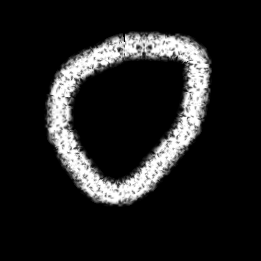

In [65]:
from PIL import Image
im = Image.open("digits/sample0.png")
im

此时如果直接将其转为 Numpy 数组会得到三个通道：

In [66]:
im_arr = np.array(im)
print(im_arr.shape)

(261, 261, 3)


因此，我们先强制转换为灰度图片（单通道），再缩放至模型的图片大小 28 x 28：

In [67]:
im = im.convert("L")
im.thumbnail((28, 28))
im_arr = np.array(im)
print(im_arr.shape)
im

(28, 28)


为了传递给模型对象，还需要先将数值归一化到 [0,1] 区间，转换为 PyTorch 的 Tensor 类型，并增加一个批次和一个通道的维度：

In [68]:
test0 = torch.tensor(im_arr / 255.0, dtype=torch.float32).view(1, 1, 28, 28)
print(test0.shape)

torch.Size([1, 1, 28, 28])


最后对图片标签进行预测：

In [69]:
pred0 = model(test0)
print(np.round(pred0.detach().cpu().numpy(), 3))

[[0.048 0.    0.    0.    0.    0.    0.    0.    0.006 0.945]]


预测结果是否符合真实情形？请对你自己绘制出的10张图片进行类似的预测操作，并评价其效果。

In [70]:
im = Image.open("digits/sample5.png")
im_arr = np.array(im)
im = im.convert("L")
im.thumbnail((28, 28))
im_arr = np.array(im)
test5 = torch.tensor(im_arr / 255.0, dtype=torch.float32).view(1, 1, 28, 28)
pred5 = model(test5)
print(np.round(pred5.detach().cpu().numpy(), 3))

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [71]:
im = Image.open("digits/sample8.png")
im_arr = np.array(im)
im = im.convert("L")
im.thumbnail((28, 28))
im_arr = np.array(im)
test8 = torch.tensor(im_arr / 255.0, dtype=torch.float32).view(1, 1, 28, 28)
pred8 = model(test8)
print(np.round(pred8.detach().cpu().numpy(), 3))

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


### 第2题

1. 目标：通过对英文名数据进行训练，构建一个 RNN 模型，实现英文名的自动生成。

2. 主要步骤：获取和整理数据，对字符串进行 one-hot 编码，创建模型结构，定义损失函数，编写训练循环，最后生成人名字符串。

3. 获取和整理数据。数据文件已存为 `data/names.txt`，先将其读取为字符串列表：

In [15]:
import io
lines = io.open("data/names.txt").read().strip().split('\n')
print(len(lines))
print(lines[0:5])

3668
['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel']


可以看出，共读取了3668个名字。为了简单起见，我们将所有的大写字母转换为小写。

In [16]:
names = [s.lower() for s in lines]
print(names[0:5])

['abbas', 'abbey', 'abbott', 'abdi', 'abel']


接下来我们需要构建一个字符的字典。对于英文名来说很简单，即26个字母。我们可以通过下面的代码直接得到。

In [17]:
import string
char_dict = string.ascii_lowercase
char_dict

'abcdefghijklmnopqrstuvwxyz'

4. 下面准备好 one-hot 编码所需的函数。编写函数 `char2index(char)`，将一个字母转换为其所在字典的位置。例如 `char2index("a")` 要返回0，`char2index("z")` 要返回25，等等。提示：使用字符串的 `.find()` 函数。

In [28]:
def char2index(char):
    if char in char_dict:
        return char_dict.find(char)
    else:
        return 26

print(char2index("z") == 25)

True


编写 `char2tensor(char)` 函数，将一个字母转换为 one-hot 向量，即该向量中第 i 个元素为1，其余为0，其中 i 表示该字母在字典中的位置。

**注意，该向量的长度应为27，因为我们要预留终止符，用 `[0.0, 0.0, ..., 1.0]` 表示**。

`char2tensor("a")` 应返回 `torch.tensor([1.0, 0.0, ...])`，`char2tensor("z")` 应返回 `torch.tensor([0.0, ..., 1.0, 0.0])`。

In [19]:
c = torch.zeros(27)

In [20]:
torch.tensor(1)

tensor(1)

In [21]:
def char2tensor(char):
    coding = torch.zeros(27)
    coding[char2index(char)] = torch.tensor(1.0)
    return coding

print(char2tensor("a"))
print(char2tensor("z"))
print(char2tensor("z").shape[0] == 27)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0.])
True


5. 构建模型。我们使用最简单的 RNN 结构，即隐藏单元是输入和上一期隐藏单元的线性变换加上 Tanh 激活函数，输出单元是隐藏单元的线性变换加上 Softmax 激活函数。输出的结果代表下一个字符的概率分布。

In [22]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.i2h = torch.nn.Linear(input_size+hidden_size, hidden_size)
        self.h2o = torch.nn.Linear(hidden_size, 27)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1)
        hidden = torch.tanh(self.i2h(combined))
        output = torch.nn.functional.softmax(self.h2o(hidden), dim=1)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

我们做一个简单的测试。请在下面的代码中加入适当的语句，使得每次运行的结果不变。根据其输出结果，请问当前模型预测字符a的下一个字符是什么？为什么？

In [23]:
rnn = RNN(input_size=27, hidden_size=10)
input = char2tensor("a")
hidden = rnn.init_hidden()
output, hidden = rnn(input.view(1, 27), hidden)
print(output)

tensor([[0.0304, 0.0364, 0.0491, 0.0442, 0.0371, 0.0395, 0.0339, 0.0299, 0.0321,
         0.0324, 0.0487, 0.0523, 0.0299, 0.0342, 0.0407, 0.0314, 0.0277, 0.0337,
         0.0446, 0.0299, 0.0310, 0.0293, 0.0383, 0.0450, 0.0426, 0.0398, 0.0361]],
       grad_fn=<SoftmaxBackward>)


6. 接下来我们定义好损失函数。与第1题中类似，预测值是一个概率分布，而真实的标签是0到26中的一个整数，代表真实的下一个字符在字典中的位置。假设当前处理的名字为"abel"，那么字符a的输出结果对应的标签是什么？请完成下面的代码。

In [33]:
target = char2index('b')

lossfn = torch.nn.NLLLoss()
loss = lossfn(torch.log(output), torch.tensor([target]))
print(loss)

tensor(5.9882, grad_fn=<NllLossBackward>)


7. 明确单个字符的损失函数的计算方法后，请在下面计算出"abel"这个观测整体的损失函数值。

In [35]:
name = 'abel'
rnn = RNN(input_size=27, hidden_size=10)
hidden = rnn.init_hidden()
lossfn = torch.nn.NLLLoss()
loss = 0

for i in range(len(name)):
    input = char2tensor(name[i])
    output, hidden = rnn(input.view(1,27), hidden)

    if i == len(name) - 1:
        target = 26
    else:
        target = char2index(name[i + 1])

    loss = loss + lossfn(torch.log(output), torch.tensor([target]))

loss = loss / len(name)
print(loss)

tensor(3.3341, grad_fn=<DivBackward0>)


8. 将上述过程在数据上进行反复迭代，训练模型。

In [31]:
np.random.seed(123)
torch.random.manual_seed(123)

n = len(names)
n_hidden = 16
n_input = 27
nepoch = 10

rnn = RNN(n_input, n_hidden)
opt = torch.optim.Adam(rnn.parameters(), lr=0.0001)
train_ind = np.arange(n)
losses = []

lossfn = torch.nn.NLLLoss()

# Loop over epochs
for k in range(nepoch):
    # Shuffle the data
    np.random.shuffle(train_ind)
    # Loop over observations. Each observation is a name
    for i in range(n):
        name = names[train_ind[i]]
        nchar = len(name)
        # Loop over the characters in the name
        # Each input character has a target, which is the index of the next character in the dictionary
        # For the last character in the name, the target is the end-of-sequence symbol, which has index 26
        loss = 0.0
        hidden = rnn.init_hidden()
        for j in range(nchar):
            input = char2tensor(name[j])
            output, hidden = rnn(input.view(1, n_input), hidden)

            if j == nchar - 1:
                target = 26
            else:
                target = char2index(name[j + 1])

            loss = loss + lossfn(torch.log(output), torch.tensor([target]))
    
        loss = loss / nchar

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        if i % 1000 == 0:
            print(f"epoch {k}, obs {i}, loss = {loss.item()}")

epoch 0, obs 0, loss = 3.3991856575012207
epoch 0, obs 1000, loss = 2.918344020843506
epoch 0, obs 2000, loss = 2.6398532390594482
epoch 0, obs 3000, loss = 3.1096529960632324
epoch 1, obs 0, loss = 2.776276111602783
epoch 1, obs 1000, loss = 2.5617995262145996
epoch 1, obs 2000, loss = 2.415987014770508
epoch 1, obs 3000, loss = 2.4527029991149902
epoch 2, obs 0, loss = 2.5975751876831055
epoch 2, obs 1000, loss = 2.585355520248413
epoch 2, obs 2000, loss = 2.5821340084075928
epoch 2, obs 3000, loss = 2.7673685550689697
epoch 3, obs 0, loss = 2.584155559539795
epoch 3, obs 1000, loss = 2.1915831565856934
epoch 3, obs 2000, loss = 2.4389891624450684
epoch 3, obs 3000, loss = 2.0150928497314453
epoch 4, obs 0, loss = 2.4576306343078613
epoch 4, obs 1000, loss = 2.9122250080108643
epoch 4, obs 2000, loss = 2.5470449924468994
epoch 4, obs 3000, loss = 2.1251466274261475
epoch 5, obs 0, loss = 2.283302068710327
epoch 5, obs 1000, loss = 2.564319133758545
epoch 5, obs 2000, loss = 2.1136810

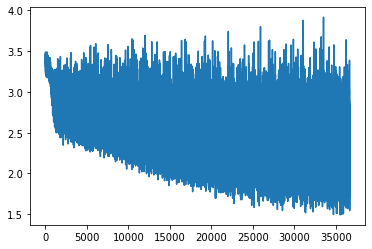

In [32]:
import matplotlib.pyplot as plt
plt.plot(losses)

9. 编写一个函数 `random_first_letter()`，它随机返回字典中的一个字符，我们将利用它来随机生成第一个字符。

In [38]:
def random_first_letter():
    idx = np.random.randint(0, 25)
    return char_dict[idx]

print(random_first_letter())
print(random_first_letter())
print(random_first_letter())

v
c
a


请简要说明如下的代码的含义（可以在代码中加入注释），然后利用它随机生成10个名字。评价生成的结果，并简要说明可以如何改进模型的效果？

In [42]:
def random_name(max_len=20):
    rnn.eval()
    first_letter = random_first_letter()
    char_ind = [char2index(first_letter)]
    input = char2tensor(first_letter)
    hidden = rnn.init_hidden()
    for i in range(max_len - 1):
        output, hidden = rnn(input.view(1, n_input), hidden)
        ind = torch.argmax(output).item()
        if ind == 26:
            break
        char_ind.append(ind)
        input.zero_()
        input[ind] = 1.0
    return "".join([char_dict[i] for i in char_ind])

In [47]:
for _ in range(10):
    print(random_name(max_len=10))

hololololo
alolololol
sololololo
rololololo
idpppppppp
bdolololol
mololololo
tdpppppppp
jlolololol
hololololo


### 第3题

利用卷积函数实现任意大整数的乘法。给定两个整数，如 183612 和 23333，用两个列表表达它们的序列：

In [49]:
n1 = [1, 8, 3, 6, 1, 2]
n2 = [2, 3, 3, 3, 3]

请编写一个函数 `integer_mult(n1, n2)`，返回 `n1 * n2` 对应的整数序列。注意不要直接调用乘法表达式（设想有两个非常大的整数，直接相乘可能会导致数值溢出）。

In [65]:
def integer_mult(n1, n2):
    poly_multi_result = np.convolve(n1, n2)
    to_next = 0
    params = []
    for j in poly_multi_result[::-1]:
        params.append((j + to_next) % 10)
        to_next = (j + to_next) // 10
    while to_next:
        params.append(to_next % 10)
        to_next = to_next // 10  
    return params[::-1]

res = integer_mult(n1, n2)
print(res)
print(res == [4, 2, 8, 4, 2, 1, 8, 7, 9, 6])

[4, 2, 8, 4, 2, 1, 8, 7, 9, 6]
True


思路：

1. 先实现多项式的乘法。例如，给定 $p(x)=1+2x+x^4$ 和 $q(x)=x+3x^2+5x^3$，计算 $r(x)=p(x)q(x)$。我们将 $p(x)$ 编码为 `p = [1, 2, 0, 0, 1]`，$q(x)$ 编码为 `q = [0, 1, 3, 5]`，请编写函数 `poly_mult(p, q)`，使得 `poly_mult(p, q) == [0, 1, 5, 11, 10, 1, 3, 5]`。

In [52]:
p = [1, 2, 0, 0, 1]
q = [0, 1, 3, 5]

def poly_mult(p, q):
    return np.convolve(p, q)

print(poly_mult(p, q) == [0, 1, 5, 11, 10,  1, 3, 5])

[ True  True  True  True  True  True  True  True]


2. 对于任意的一个整数，将其看成是某个多项式在 $x=10$ 处的取值，如 $123 = p_1(10)$，$p_1(x)=3+2x+x^2$，$5310 = p_2(10)$，$p_2(x)=x+3x^2+5x^3$，注意需要适当将序列反序。因此，要计算 $123\times 5310$，相当于计算 $r(10)$ 的值，但为了避免直接进行乘法运算（防止溢出），可以先计算 $r(x)$ 的表达式（等价于其系数向量），然后建立起 $r(x)$ 的系数与 $r(10)$ 之间的联系（见如下第3点）。

3. 如果一个多项式 $r(x)$ 所有的系数都是0到9之间的整数，那么 $r(x)$ 和 $r(10)$ 的关系非常直接，比如若 $r(x)=1+2x+5x^2+3x^3$，则 $r(10)=3521$。但如果有系数超过10，就需要考虑进位的影响，比如 $r(x)=1+11x+2x^2$，$r(10)=311$。此时可以从 $r(x)$ 的第一项开始逐项进位，构造一个新的多项式 $r'(x)=1+x+3x^2$，满足 $r'(10)=r(10)$，且 $r'(x)$ 所有的系数都不超过10。 

4. 综合利用以上信息，完成本题的算法编写。并测试 23742389754298365 * 809723950 的结果。

In [91]:
def integer_mult(n1, n2):
    poly_multi_result = np.convolve(n1, n2)
    to_next = 0
    params = []
    for j in poly_multi_result[::-1]:
        params.append((j + to_next) % 10)
        to_next = (j + to_next) // 10
    while to_next:
        params.append(to_next % 10)
        to_next = to_next // 10  
    return params[::-1]

def big_number_multi(params):
    result = 0
    for i, j in enumerate(params[::-1]):
        result = result + (10**i)*j
    return result

将两个数字表示成列表表达形式

In [85]:
n1 = [2,3,7,4,2,3,8,9,7,5,4,2,9,8,3,6,5]
n2 = [8,0,9,7,2,3,9,5,0]

计算乘积多项式系数

In [87]:
poly_params = integer_mult(n1, n2)
print(poly_params)

[1, 9, 2, 2, 4, 7, 8, 1, 6, 1, 4, 2, 9, 0, 0, 0, 1, 5, 8, 6, 3, 4, 1, 7, 5, 0]


将$x=10$带入多项式中进行计算，得到乘积

In [92]:
big_number_multi(poly_params)

1.9224781614290002e+25